# Ensemble Methods: *Boosting* - Movie Quality

## Importing libs

In [1]:
# Data manipulation modules
import numpy as np
import pandas as pd

# Plotting packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Performance metrics
import preditiva_EN


## Importing Database

In [2]:
df = pd.read_csv('IMDB-Movie-Data.csv')
df['Binary_Rating'] = np.where(df['Rating'] >= 7, 1, 0)
df.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,Binary_Rating
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0,1
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0,1
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0,1
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0,1
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0,0


### Missing Values

In [3]:
df.isnull().sum()


Rank                    0
Title                   0
Genre                   0
Description             0
Director                0
Actors                  0
Year                    0
Runtime (Minutes)       0
Rating                  0
Votes                   0
Revenue (Millions)    128
Metascore              64
Binary_Rating           0
dtype: int64

In [4]:
# Check the status of columns with missing values
df.describe()

,Rank,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,Binary_Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,872.000000,936.000000,1000.000000
mean,500.500000,2012.783000,113.172000,6.723200,1.698083e+05,82.956376,58.985043,0.445000
std,288.819436,3.205962,18.810908,0.945429,1.887626e+05,103.253540,17.194757,0.497214
min,1.000000,2006.000000,66.000000,1.900000,6.100000e+01,0.000000,11.000000,0.000000
25%,250.750000,2010.000000,100.000000,6.200000,3.630900e+04,13.270000,47.000000,0.000000
50%,500.500000,2014.000000,111.000000,6.800000,1.107990e+05,47.985000,59.500000,0.000000
75%,750.250000,2016.000000,123.000000,7.400000,2.399098e+05,113.715000,72.000000,1.000000
max,1000.000000,2016.000000,191.000000,9.000000,1.791916e+06,936.630000,100.000000,1.000000


In [5]:
# Since Revenue (Millions) has outliers and Metascore doesn't:
# Impute revenue using the median (to avoid the influence of outliers)
df['Revenue (Millions)'].fillna(df['Revenue (Millions)'].median(), inplace=True)

# Impute metascore using the mean (distribution is well-behaved)
df['Metascore'].fillna(df['Metascore'].mean(), inplace=True)

### Missings

In [6]:
df.isnull().sum()

Rank                  0
Title                 0
Genre                 0
Description           0
Director              0
Actors                0
Year                  0
Runtime (Minutes)     0
Rating                0
Votes                 0
Revenue (Millions)    0
Metascore             0
Binary_Rating         0
dtype: int64

### Duplicated

In [7]:
df.duplicated().sum()

0

### Data Types

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rank                1000 non-null   int64  
 1   Title               1000 non-null   object 
 2   Genre               1000 non-null   object 
 3   Description         1000 non-null   object 
 4   Director            1000 non-null   object 
 5   Actors              1000 non-null   object 
 6   Year                1000 non-null   int64  
 7   Runtime (Minutes)   1000 non-null   int64  
 8   Rating              1000 non-null   float64
 9   Votes               1000 non-null   int64  
 10  Revenue (Millions)  1000 non-null   float64
 11  Metascore           1000 non-null   float64
 12  Binary_Rating       1000 non-null   int32  
dtypes: float64(3), int32(1), int64(4), object(5)
memory usage: 97.8+ KB


In [9]:
# 1️⃣ Drop unnecessary columns
df = df.drop(columns=['Title', 'Description', 'Director', 'Actors'])

In [10]:
# First, split the multiple genres
df['Genre'] = df['Genre'].str.split(',')

# Now, use get_dummies for each genre
df_genre_dummies = df['Genre'].explode().str.get_dummies().groupby(level=0).sum()

# Concatenate back to the original dataframe
df = pd.concat([df, df_genre_dummies], axis=1)


In [11]:
df.head()

,Rank,Genre,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,Binary_Rating,Action,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,"[Action, Adventure, Sci-Fi]",2014,121,8.1,757074,333.13,76.0,1,1,...,0,0,0,0,0,1,0,0,0,0
1,2,"[Adventure, Mystery, Sci-Fi]",2012,124,7.0,485820,126.46,65.0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,3,"[Horror, Thriller]",2016,117,7.3,157606,138.12,62.0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,4,"[Animation, Comedy, Family]",2016,108,7.2,60545,270.32,59.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,"[Action, Adventure, Fantasy]",2016,123,6.2,393727,325.02,40.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Drop unnecessary column
df = df.drop('Genre', axis=1)
df.head()

,Rank,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,Binary_Rating,Action,Adventure,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,2014,121,8.1,757074,333.13,76.0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1,2,2012,124,7.0,485820,126.46,65.0,1,0,1,...,0,0,0,1,0,1,0,0,0,0
2,3,2016,117,7.3,157606,138.12,62.0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
3,4,2016,108,7.2,60545,270.32,59.0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2016,123,6.2,393727,325.02,40.0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis

### Dispersion by Class

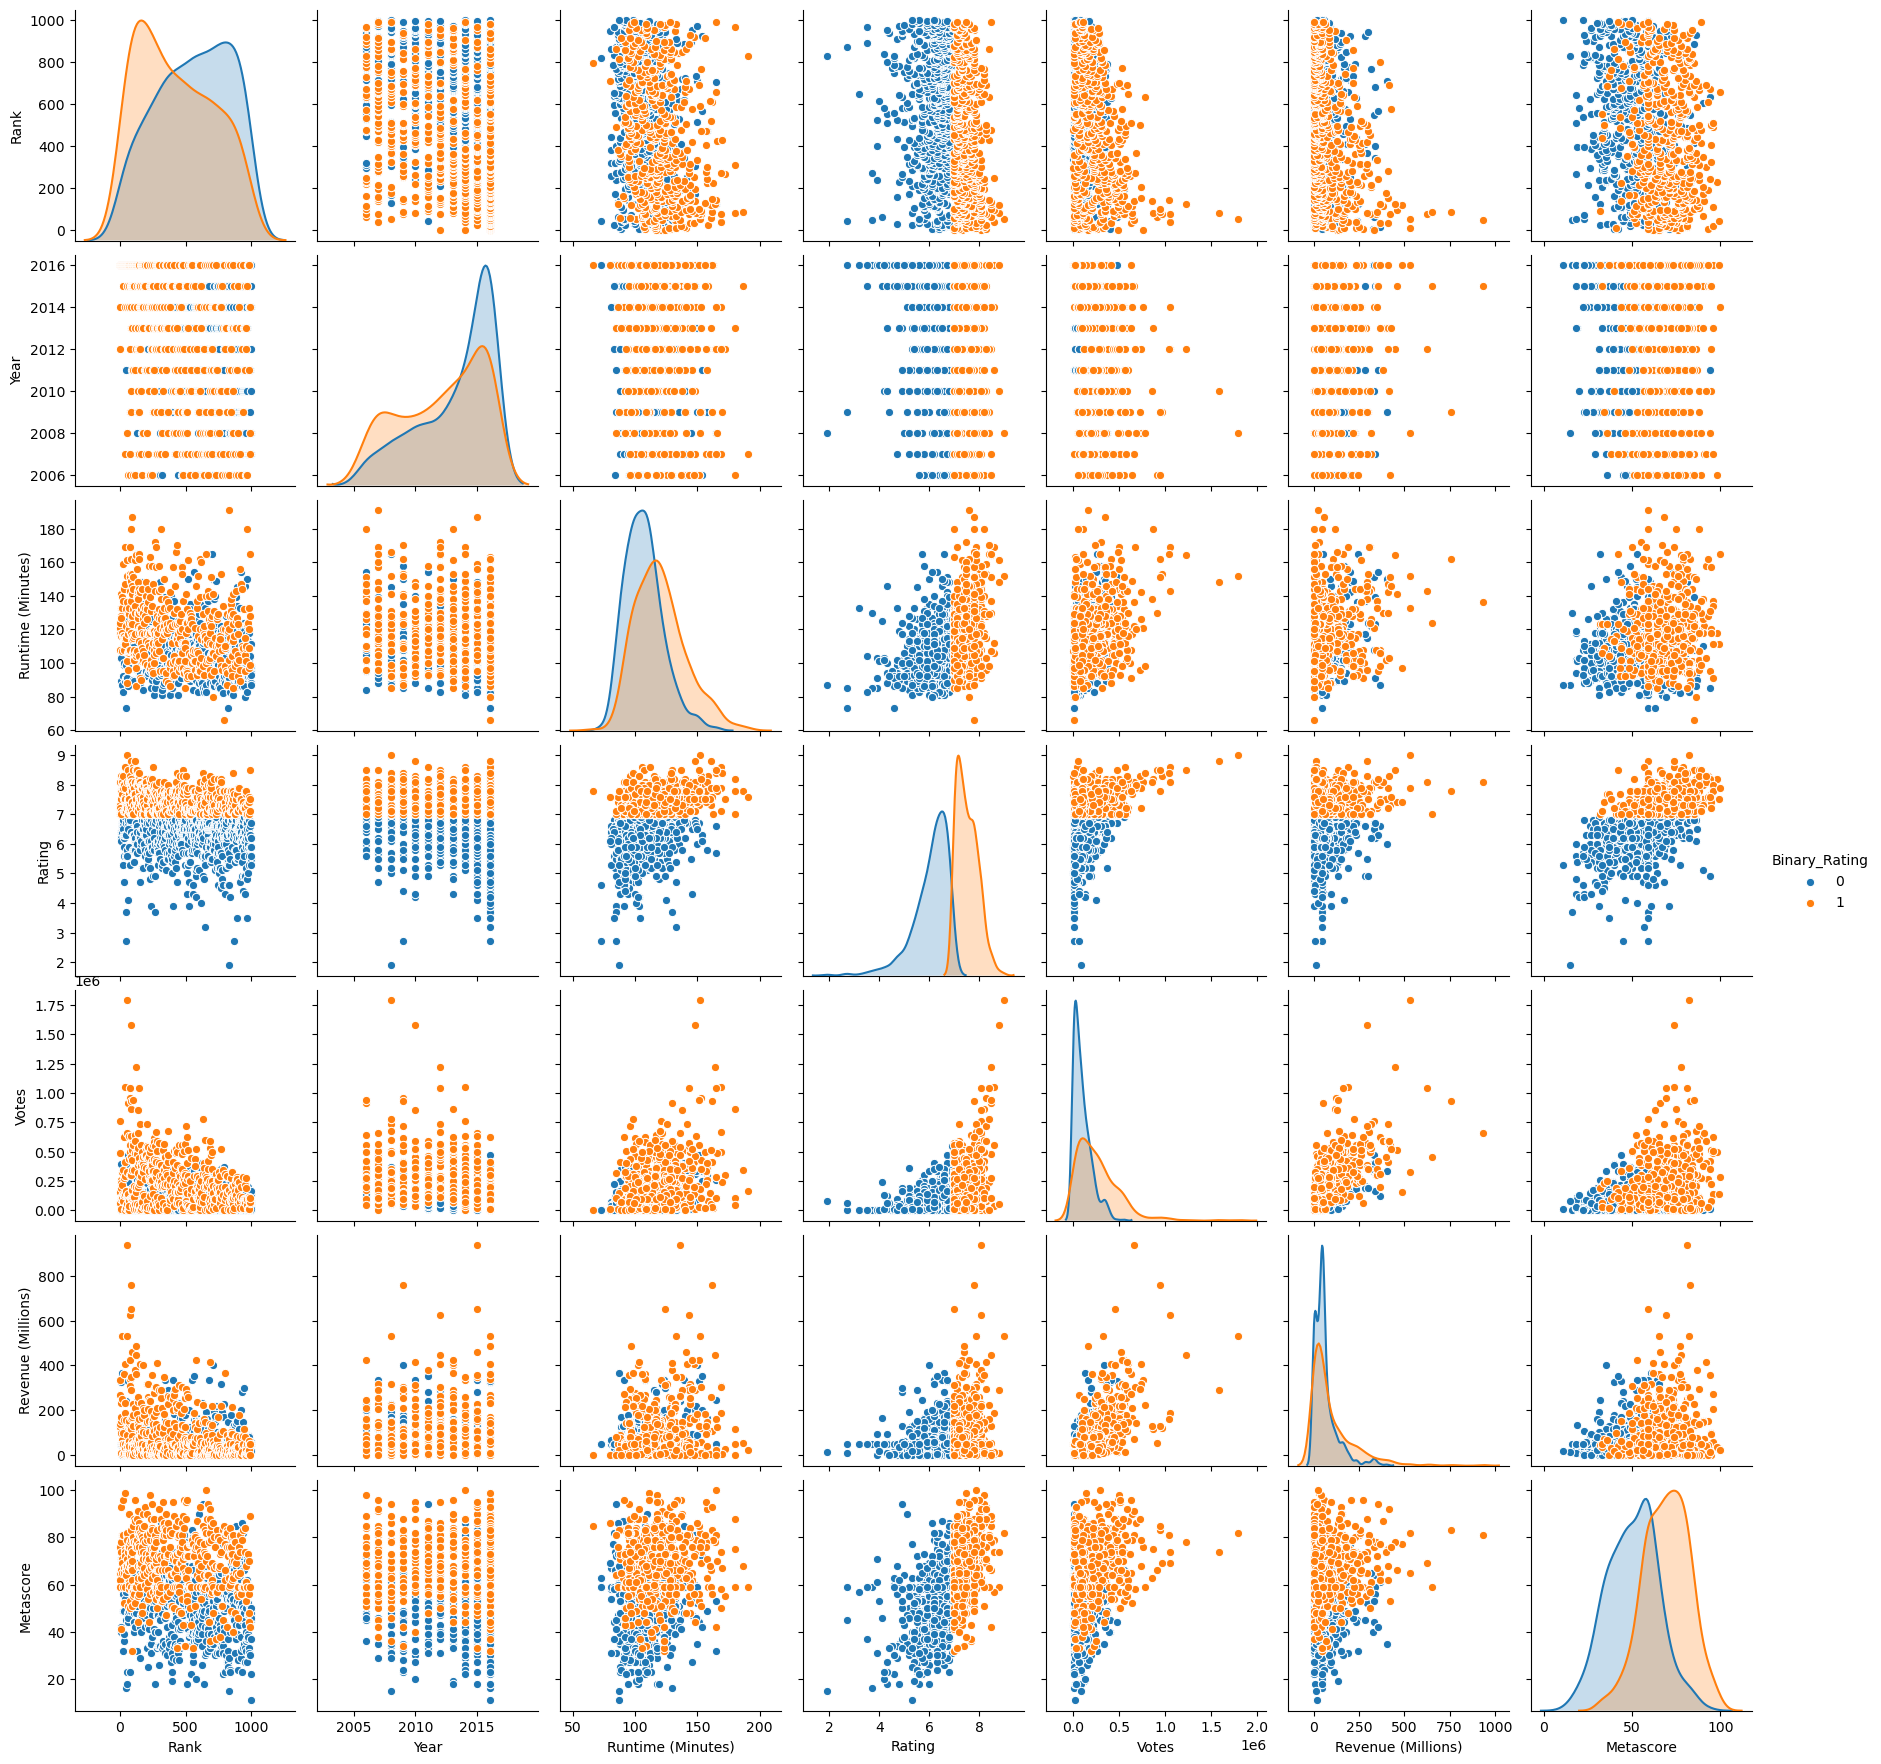

In [13]:
import matplotlib
matplotlib.use('module://ipykernel.pylab.backend_inline')

sns.pairplot(df[['Rank', 'Year', 'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)', 'Metascore', 'Binary_Rating']], hue='Binary_Rating')


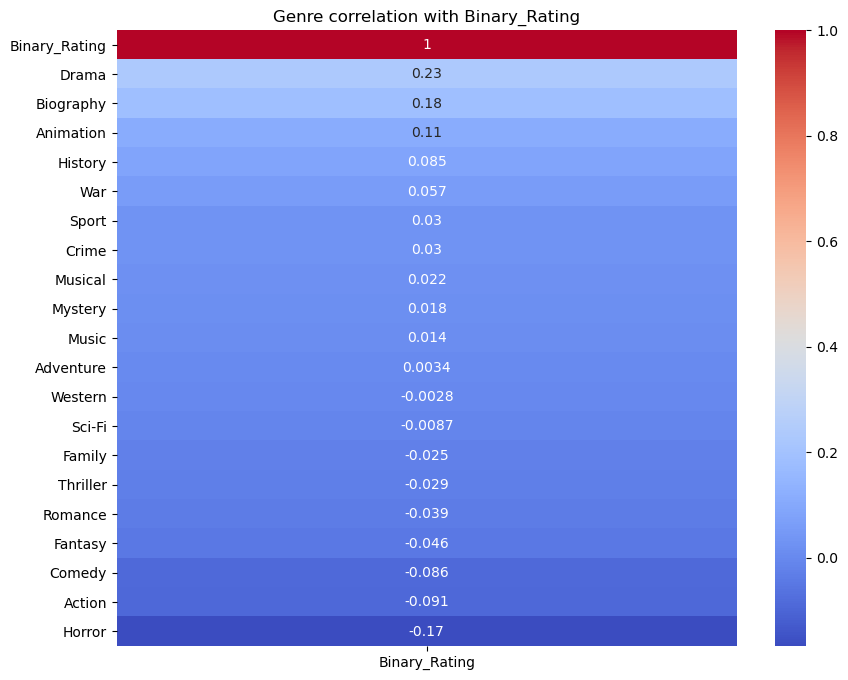

In [14]:
# Correlation between dummy variables and Binary_Rating
corr = df[df_genre_dummies.columns.tolist() + ['Binary_Rating']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr[['Binary_Rating']].sort_values(by='Binary_Rating', ascending=False),
            annot=True, cmap='coolwarm')
plt.title('Genre correlation with Binary_Rating')
plt.show()

### Pandas Profiling and SweetViz Reports

In [15]:
perfil_pp, perfil_sv = preditiva_EN.generate_aed_reports(df=df,
                                                     target_feat='Binary_Rating')
sns.reset_defaults()

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 16.91it/s]
:FEATURES DONE:                    |█████████████████████| [100%]   00:08  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)


Creating Associations graph... DONE!
Report base_aed_sv.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


## Model Development  

### Definition of *Target* and *Features*

In [16]:
df.head(2)

,Rank,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore,Binary_Rating,Action,Adventure,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,2014,121,8.1,757074,333.13,76.0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1,2,2012,124,7.0,485820,126.46,65.0,1,0,1,...,0,0,0,1,0,1,0,0,0,0


In [17]:
df.columns

Index(['Rank', 'Year', 'Runtime (Minutes)', 'Rating', 'Votes',
       'Revenue (Millions)', 'Metascore', 'Binary_Rating', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [18]:
# Target
y_var = 'Binary_Rating'
y = df[y_var]

# Features 
x_var = ['Rank', 'Year', 'Runtime (Minutes)', 'Votes',
       'Revenue (Millions)', 'Metascore', 'Action',
       'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'
    ]
x = df[x_var]

In [19]:
y.head()

0    1
1    1
2    1
3    1
4    0
Name: Binary_Rating, dtype: int32

In [20]:
x.head()

,Rank,Year,Runtime (Minutes),Votes,Revenue (Millions),Metascore,Action,Adventure,Animation,Biography,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,2014,121,757074,333.13,76.0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2,2012,124,485820,126.46,65.0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
2,3,2016,117,157606,138.12,62.0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,4,2016,108,60545,270.32,59.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2016,123,393727,325.02,40.0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Train-Test Split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.30,
                                                    random_state=42)

In [22]:
x_train.shape

(700, 26)

In [23]:
x_test.shape

(300, 26)

### Ensemble Methods: *Boosting* - **AdaBoost**

In [24]:
model_ada = AdaBoostClassifier(n_estimators=75,
                                learning_rate = 0.3,
                                random_state = 42)

model_ada.fit(x_train, y_train)

# Performance Metrics
performance_ada = preditiva_EN.calculate_performance(model_ada, 
                                          x_train, y_train,
                                          x_test, y_test)
performance_ada

,Train,Test,Variation
Acurácia,0.882857,0.826667,-0.06
AUROC,0.948057,0.893926,-0.06
KS,0.769396,0.648823,-0.16
Precision,0.883333,0.813953,-0.08
Recall,0.849359,0.789474,-0.07
F1,0.866013,0.801527,-0.07


### Ensemble Methods: *Boosting* - **Gradient Boosting**

In [25]:
model_gb = GradientBoostingClassifier(n_estimators=100,
                                       learning_rate = 0.1,
                                       subsample=0.7,
                                       min_samples_leaf=30,
                                       max_depth=2,
                                       random_state = 42)

model_gb.fit(x_train, y_train)

# Performance Metrics
performance_gb = preditiva_EN.calculate_performance(model_gb,
                                         x_train, y_train,
                                         x_test, y_test)
performance_gb

,Train,Test,Variation
Acurácia,0.897143,0.830000,-0.07
AUROC,0.961753,0.897123,-0.07
KS,0.798242,0.659403,-0.17
Precision,0.900000,0.836066,-0.07
Recall,0.865385,0.766917,-0.11
F1,0.882353,0.800000,-0.09


### Model Comparison

In [26]:
performance_ada

,Train,Test,Variation
Acurácia,0.882857,0.826667,-0.06
AUROC,0.948057,0.893926,-0.06
KS,0.769396,0.648823,-0.16
Precision,0.883333,0.813953,-0.08
Recall,0.849359,0.789474,-0.07
F1,0.866013,0.801527,-0.07


In [27]:
performance_gb

,Train,Test,Variation
Acurácia,0.897143,0.830000,-0.07
AUROC,0.961753,0.897123,-0.07
KS,0.798242,0.659403,-0.17
Precision,0.900000,0.836066,-0.07
Recall,0.865385,0.766917,-0.11
F1,0.882353,0.800000,-0.09


### Feature Importance

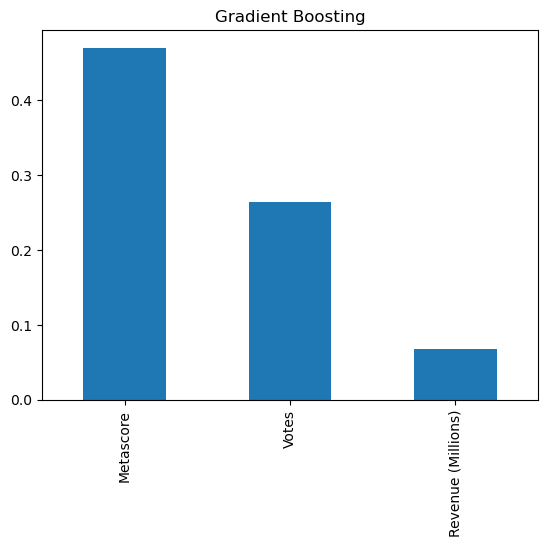

In [28]:
# Feature Importance in Gradient Boosting
model_gb_feat_importances = pd.Series(model_gb.feature_importances_,
                                       index=x.columns)
model_gb_feat_importances.nlargest(3).plot(kind='bar', title='Gradient Boosting');
plt.show()

In [29]:
# Display the feature importances of the Gradient Boosting model
print(model_gb.feature_importances_)

# Display the top 10 most important features
print(model_gb_feat_importances.nlargest(10))

[0.03880027 0.01303631 0.05019469 0.26443187 0.0683057  0.46979266
 0.01063204 0.00125823 0.         0.02133765 0.         0.00297201
 0.04839103 0.         0.00387338 0.         0.00697415 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Metascore             0.469793
Votes                 0.264432
Revenue (Millions)    0.068306
Runtime (Minutes)     0.050195
Drama                 0.048391
Rank                  0.038800
Biography             0.021338
Year                  0.013036
Action                0.010632
Horror                0.006974
dtype: float64
